# Evaluate generalizability of the model across holdout plate(s)

## Import libraries

In [1]:
import pandas as pd
import pathlib
from joblib import load
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_recall_curve,
)
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
MODEL_ID = "randomforest"
ROLE = "generalizability"

import logging
from datetime import datetime
import pathlib

# ============================================
# 1) Choose a RUN_ID
# ============================================
RUN_ID = datetime.now().strftime("%m_%d_%H_%M")


RUN_ID = "12_08_08_12"

ANALYSIS_TYPE = "generalizability"


def setup_logger(
    run_id: str,
    model_id: str,
    role: str,
    log_dir: str = "logs",
    analysis_type: str = ANALYSIS_TYPE,
) -> logging.Logger:
    """
    Create a logger that writes to both stdout and a log file.

    - Logger name:  "<analysis_type>_<run_id>_<model_id>_<role>"
    - Log file:     "log_<analysis_type>_<run_id>_<model_id>.log" in `log_dir`
      (shared by all notebooks for the same model & run & analysis_type).
    """
    log_path = pathlib.Path(log_dir)
    log_path.mkdir(exist_ok=True)

    logger_name = f"{analysis_type}_{run_id}_{model_id}_{role}"
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.INFO)
    logger.propagate = False  

    # Avoid adding handlers multiple times if the cell is re-run
    if not logger.handlers:
        # Common formatter for both handlers
        formatter = logging.Formatter(
            fmt="%(asctime)s [%(name)s] %(levelname)s: %(message)s",
            datefmt="%Y-%m-%dT%H:%M:%S",
        )

        # Stream handler (stdout)
        stream_handler = logging.StreamHandler()
        stream_handler.setLevel(logging.INFO)
        stream_handler.setFormatter(formatter)
        logger.addHandler(stream_handler)

        # File handler (one file per analysis_type + run_id + model_id)
        log_file = log_path / f"log_{analysis_type}_{run_id}_{model_id}.log"
        file_handler = logging.FileHandler(log_file)
        file_handler.setLevel(logging.INFO)
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)
        print(log_path)

    return logger

logger = setup_logger(RUN_ID, MODEL_ID, ROLE)
logger.info("Initialized logger.")


2025-12-06T08:17:30 [generalizability_12_08_08_12_randomforest_generalizability] INFO: Initialized logger.


logs


## Set paths and variables

In [3]:
# Set data type for the generalizability evaluation
data_cleaned = "cleaned"

# Set suffix for data files if using QC or cleaned data
if data_cleaned == "cleaned":
    suffix = "_qc"
else:
    suffix = ""

# Path to folder holding RF model and encoder files
model_dir = pathlib.Path("../1.train_models/data_randomforest")

# Load in the RF label encoder
le = load(pathlib.Path(f"{model_dir}/trained_nf1_model_label_encoder{suffix}.joblib"))

# Load in the RF model
model = load(pathlib.Path(f"{model_dir}/trained_nf1_model{suffix}.joblib"))

# Path to RF results directory
results_dir = pathlib.Path("./results_randomforest")
results_dir.mkdir(exist_ok=True)

# Set the random seed
rng = np.random.default_rng(0)


## Load in plate with two cell lines (Plate 6)

In [4]:
# Set directory to find the plate 6 data from based on data type
directory = (
    "single_cell_profiles/cleaned_sc_profiles"
    if data_cleaned == "cleaned"
    else "single_cell_profiles"
)

# Root of the nf1_schwann_cell_painting_data repo, relative to this notebook
cp_root = pathlib.Path("../../nf1_schwann_cell_painting_data")

plate6_path = (
    cp_root
    / "3.processing_features"
    / "data"
    / directory
    / "Plate_6_sc_normalized.parquet"
)

logger.info(f"Loading Plate 6 data from: {plate6_path.resolve()}")
plate6_df = pd.read_parquet(plate6_path)

# Count rows before dropping NaNs
initial_count = plate6_df.shape[0]

# Drop rows with NaNs
plate6_df = plate6_df.dropna()

# Count rows after dropping NaNs
final_count = plate6_df.shape[0]

logger.info(f"Dropped rows: {initial_count - final_count}")
logger.info(plate6_df.shape)
plate6_df.head()


2025-12-06T08:17:30 [generalizability_12_08_08_12_randomforest_generalizability] INFO: Loading Plate 6 data from: /Users/marktalbot/Documents/VC Studio Homework Folders/HighRisk/nf1_schwann_cell_painting_data/3.processing_features/data/single_cell_profiles/cleaned_sc_profiles/Plate_6_sc_normalized.parquet
2025-12-06T08:17:31 [generalizability_12_08_08_12_randomforest_generalizability] INFO: Dropped rows: 157
2025-12-06T08:17:31 [generalizability_12_08_08_12_randomforest_generalizability] INFO: (6705, 2319)


,Metadata_WellRow,Metadata_WellCol,Metadata_Well,Metadata_Site,Metadata_number_of_singlecells,Metadata_gene_name,Metadata_genotype,Metadata_Institution,Metadata_seed_density,Metadata_ImageNumber,...,Nuclei_Texture_Variance_DAPI_3_02_256,Nuclei_Texture_Variance_DAPI_3_03_256,Nuclei_Texture_Variance_GFP_3_00_256,Nuclei_Texture_Variance_GFP_3_01_256,Nuclei_Texture_Variance_GFP_3_02_256,Nuclei_Texture_Variance_GFP_3_03_256,Nuclei_Texture_Variance_RFP_3_00_256,Nuclei_Texture_Variance_RFP_3_01_256,Nuclei_Texture_Variance_RFP_3_02_256,Nuclei_Texture_Variance_RFP_3_03_256
0,B,2,B2,2,129,NF1,WT,iNFixion,1000,88,...,0.298442,0.374391,0.276939,0.298220,0.302561,0.302751,0.194872,0.241218,0.226816,0.209415
1,B,2,B2,31,129,NF1,WT,iNFixion,1000,90,...,1.311262,1.242450,3.710993,3.807023,3.874444,3.819233,0.116763,0.097229,0.184310,0.180095
3,B,2,B2,9,129,NF1,WT,iNFixion,1000,102,...,1.178902,1.209370,-0.835256,-0.830575,-0.841881,-0.834557,-0.530253,-0.534469,-0.545300,-0.534969
4,B,2,B2,10,129,NF1,WT,iNFixion,1000,67,...,1.539201,1.619689,-0.420374,-0.422610,-0.369734,-0.304624,0.116997,0.094581,0.134686,0.122749
5,B,2,B2,13,129,NF1,WT,iNFixion,1000,70,...,0.890088,0.867419,-0.629785,-0.605068,-0.611527,-0.618355,-0.297538,-0.318409,-0.322444,-0.302633


## Generate a shuffled dataset from the loaded in plate

In [5]:
# Shuffle the features randomly, excluding columns that start with "Metadata_"
shuffled_plate6_df = plate6_df.apply(
    lambda x: rng.permutation(x) if not x.name.startswith("Metadata_") else x
)

# Print shape and head of data
logger.info(shuffled_plate6_df.shape)
shuffled_plate6_df.head()

2025-12-06T08:17:31 [generalizability_12_08_08_12_randomforest_generalizability] INFO: (6705, 2319)


,Metadata_WellRow,Metadata_WellCol,Metadata_Well,Metadata_Site,Metadata_number_of_singlecells,Metadata_gene_name,Metadata_genotype,Metadata_Institution,Metadata_seed_density,Metadata_ImageNumber,...,Nuclei_Texture_Variance_DAPI_3_02_256,Nuclei_Texture_Variance_DAPI_3_03_256,Nuclei_Texture_Variance_GFP_3_00_256,Nuclei_Texture_Variance_GFP_3_01_256,Nuclei_Texture_Variance_GFP_3_02_256,Nuclei_Texture_Variance_GFP_3_03_256,Nuclei_Texture_Variance_RFP_3_00_256,Nuclei_Texture_Variance_RFP_3_01_256,Nuclei_Texture_Variance_RFP_3_02_256,Nuclei_Texture_Variance_RFP_3_03_256
0,B,2,B2,2,129,NF1,WT,iNFixion,1000,88,...,-0.785389,-0.211733,-0.604239,0.070803,3.517192,-0.807908,-0.854015,-0.263752,0.210540,-0.385756
1,B,2,B2,31,129,NF1,WT,iNFixion,1000,90,...,0.795314,-1.437351,-0.844778,-0.223577,-0.849571,1.529087,2.251560,-1.007663,1.056292,-0.929594
3,B,2,B2,9,129,NF1,WT,iNFixion,1000,102,...,-0.750314,0.536012,1.654945,-0.290821,0.072689,-0.448971,-0.632908,0.253282,1.568698,-0.724448
4,B,2,B2,10,129,NF1,WT,iNFixion,1000,67,...,-1.120582,-0.933243,-0.224670,-0.737875,-0.695419,-0.466556,1.729137,-0.486301,-1.030223,-0.647793
5,B,2,B2,13,129,NF1,WT,iNFixion,1000,70,...,-0.614151,-1.735935,-0.562743,0.202354,-0.644787,-0.629022,-0.603841,-0.669573,-0.439405,0.286585


## Apply model to final and shuffled versions of the plate data

In [6]:
# Create list of the metadata columns only
meta_cols = [col for col in plate6_df.columns if "Metadata" in col]

# Define a dictionary to handle both data types
data_dict = {"final": plate6_df, "shuffled": shuffled_plate6_df}

# Initialize a list to store processed dataframes
processed_dfs = []

# Loop through the data dictionary to create probability dataframes
for data_type, data in data_dict.items():
    # Ensure no duplicates in data and reset index
    data = data.drop_duplicates().reset_index(drop=True)

    # Predict probabilities and labels
    probabilities = model.predict_proba(data[model.feature_names_in_])[:, 1]
    predicted_genotype = model.predict(
        data[model.feature_names_in_]
    )  # outputs as binary labels

    # Make a copy of the column to avoid modifying the original dataframe
    true_genotype = data["Metadata_genotype"].copy()

    # Set HET values to 2 explicitly
    true_genotype.loc[true_genotype == "HET"] = 2

    # Use label encoder for the remaining values (excluding HET)
    mask = true_genotype != 2  # Identify rows that are not HET
    true_genotype.loc[mask] = le.transform(true_genotype.loc[mask])

    # Convert dtype to integer
    true_genotype = true_genotype.astype(int)

    # Create a dataframe with probabilities and predictions
    probability_df = pd.DataFrame(
        {
            "probability_WT": probabilities,
            "predicted_genotype": predicted_genotype,
            "true_genotype": true_genotype,
            "data_type": data_type,
        },
        index=data.index,  # Ensure alignment with original data
    )

    # Add metadata columns (reset index to align lengths)
    metadata_df = data[meta_cols].reset_index(drop=True)
    assert len(probability_df) == len(
        metadata_df
    ), "Row count mismatch between probabilities and metadata!"

    full_df = pd.concat([probability_df, metadata_df], axis=1)
    processed_dfs.append(full_df)

# Combine all dataframes
combined_df = pd.concat(processed_dfs, axis=0).reset_index(drop=True)

# Save to Parquet with qc suffix if data is cleaned
if data_cleaned == "cleaned":
    output_file = (
        pathlib.Path(results_dir)
        / "plate_6_single_cell_probabilities_rf_qc.parquet"
    )
else:
    output_file = (
        pathlib.Path(results_dir)
        / "plate_6_single_cell_probabilities_rf.parquet"
    )

combined_df.to_parquet(output_file)


## Split the probability data by Institution

In [7]:
# Create dictionary with the split dataframes based on Institution
institution_dfs = {
    institution: combined_df[combined_df["Metadata_Institution"] == institution].copy()
    for institution in combined_df["Metadata_Institution"].unique()
}

## Generate PR curve results (for pre-visualization)

In [8]:
precision_recall_data = []

for institution, df in institution_dfs.items():
    for data_type in ["final", "shuffled"]:  # Compute separately for both types
        # Subset for data type and remove the HET cells from evaluation
        subset_df = df[
            (df["data_type"] == data_type) & (df["Metadata_genotype"] != "HET")
        ]

        # Compute precision-recall curve
        precision, recall, _ = precision_recall_curve(
            subset_df["true_genotype"], subset_df["probability_WT"]
        )

        institution_results = pd.DataFrame(
            {
                "Precision": precision[:-1],
                "Recall": recall[:-1],
                "Metadata_Institution": institution,
                "data_type": data_type,
            }
        )

        precision_recall_data.append(institution_results)

# Combine all institution-based PR data
precision_recall_df = pd.concat(precision_recall_data, ignore_index=True)

# Save PR curve data to parquet file with qc suffix if data is cleaned
# Save PR curve data to parquet file with qc suffix if data is cleaned (RF version)
if data_cleaned == "cleaned":
    pr_curve_file = (
        pathlib.Path(results_dir)
        / "plate6_precision_recall_final_model_rf_qc.parquet"
    )
else:
    pr_curve_file = (
        pathlib.Path(results_dir)
        / "plate6_precision_recall_final_model_rf.parquet"
    )

precision_recall_df.to_parquet(pr_curve_file)



logger.info(precision_recall_df.shape)
precision_recall_df.head()

2025-12-06T08:17:33 [generalizability_12_08_08_12_randomforest_generalizability] INFO: (835, 4)


,Precision,Recall,Metadata_Institution,data_type
0,0.677801,1.000000,iNFixion,final
1,0.678273,1.000000,iNFixion,final
2,0.678522,0.998973,iNFixion,final
3,0.678297,0.997947,iNFixion,final
4,0.678073,0.996920,iNFixion,final


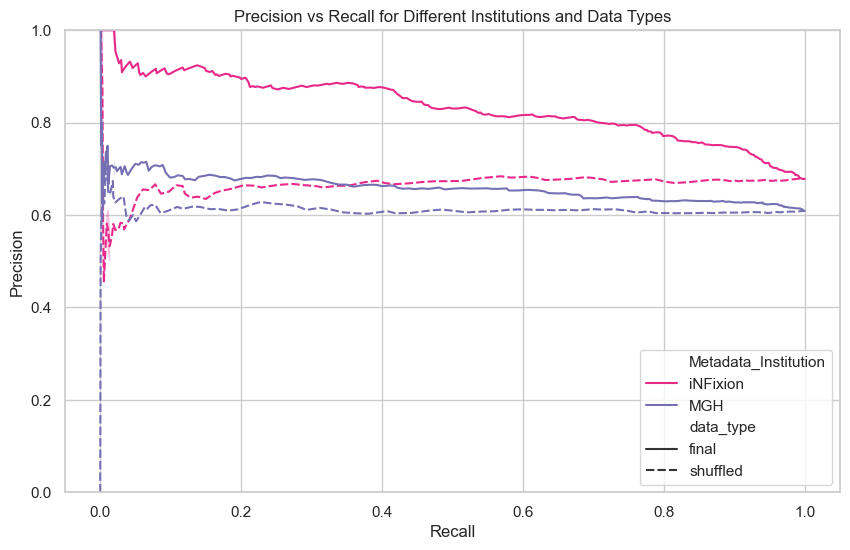

In [9]:
# Set the style of the plot
sns.set_theme(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Define a color palette based on Set2 (you can adjust n_colors to match your needs)
institution_palette = sns.color_palette("Dark2", n_colors=8)

# Create a mapping dictionary of institutions to specific colors from Set2
institution_color_map = {
    "MGH": institution_palette[2],
    "iNFixion": institution_palette[3],
}

# Plot the data
sns.lineplot(
    data=precision_recall_df,
    x="Recall",
    y="Precision",
    hue="Metadata_Institution",
    style="data_type",
    palette=institution_color_map,
    dashes=True,
)

# Set y-axis limits
plt.ylim(0, 1)

# Add labels and title
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall for Different Institutions and Data Types")
plt.legend(loc="lower right", bbox_to_anchor=(1, 0))
plt.show()

## Generate accuracy scores per institution and data type (final or shuffled)

In [10]:
# Calculate accuracy per institution and data type (final or shuffled) without the HET cells
accuracy_per_group = (
    combined_df[combined_df["Metadata_genotype"] != "HET"]
    .groupby(["Metadata_Institution", "data_type"])
    .apply(lambda x: accuracy_score(x["true_genotype"], x["predicted_genotype"]))
    .reset_index(name="accuracy")
)

# Save accuracy data to parquet file with qc suffix if data is cleaned (RF version)
if data_cleaned == "cleaned":
    accuracy_file = (
        pathlib.Path(results_dir) / "plate6_accuracy_final_model_rf_qc.parquet"
    )
else:
    accuracy_file = (
        pathlib.Path(results_dir) / "plate6_accuracy_final_model_rf.parquet"
    )

accuracy_per_group.to_parquet(accuracy_file)

accuracy_per_group


,Metadata_Institution,data_type,accuracy
0,MGH,final,0.592814
1,MGH,shuffled,0.562170
2,iNFixion,final,0.615866
3,iNFixion,shuffled,0.609603


## Generate bar plot (for pre-visualization)

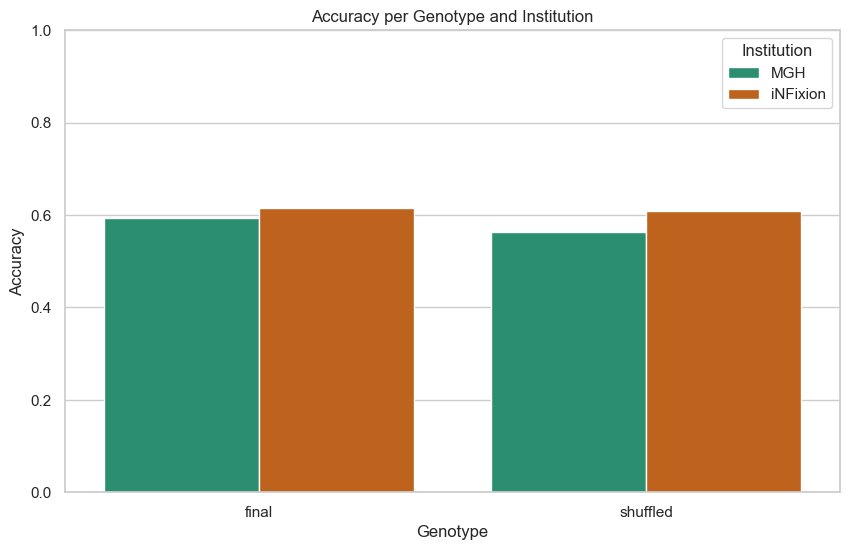

In [11]:
# Set the style of the plot
sns.set_theme(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(
    data=accuracy_per_group,
    x="data_type",
    y="accuracy",
    hue="Metadata_Institution",
    palette="Dark2",
    errorbar=None,
)

# Set y-axis limits
plt.ylim(0, 1)

# Add labels and title
plt.xlabel("Genotype")
plt.ylabel("Accuracy")
plt.title("Accuracy per Genotype and Institution")
plt.legend(title="Institution")
plt.show()

## Look at how the accuracies break down per genotype

In [12]:
# Calculate accuracy per genotype, institution and data type (final or shuffled)
accuracy_per_group = (
    combined_df[combined_df["Metadata_genotype"] != "HET"]
    .groupby(["Metadata_genotype", "Metadata_Institution", "data_type"])
    .apply(lambda x: accuracy_score(x["true_genotype"], x["predicted_genotype"]))
    .reset_index(name="accuracy")
)

accuracy_per_group

,Metadata_genotype,Metadata_Institution,data_type,accuracy
0,Null,MGH,final,0.300630
1,Null,MGH,shuffled,0.168317
2,Null,iNFixion,final,0.730022
3,Null,iNFixion,shuffled,0.140389
4,WT,MGH,final,0.780671
5,WT,MGH,shuffled,0.815394
6,WT,iNFixion,final,0.561602
7,WT,iNFixion,shuffled,0.832649
